# <font color=#2e86c1> Chemical Exchange </font>  

<a href="https://githubtocolab.com/alsinmr/ConferenceExamples/blob/master/JupyterBook/GNMR2025/Exchange_Colab.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg"></a>

Chemical exchange is an important phenomenon in magnetic resonance, where a chemical or physical change in a molecule gives rise to a modulation in the chemical shift for a given spin. Depending on the rate of exchange between two or more chemical shifts, we may observe the effects of exchange using a number of different experiments.

The following tutorial will introduce this concept and investigate effects of various parameters on several different experiments. We'll use SLEEPY [http://sleepy-nmr.org](http://sleepy-nmr.org) to support our investigations, so take some time to experiment with the software as you go.

![pulse sequences](sequences.png)

The basic formulas for calculating the influence of exchange on a 1D spectrum are the Bloch-McConnell equations:

H.M. McConnell. [*J. Chem. Phys.*](https://doi.org/10.1063/1.1744152), **1958**, 28, 430-431.

In [1]:
# Make sure SLEEPY is installed and on the path
import sys
import os
if 'google.colab' in sys.modules: #Colab
    !pip install sleepy-nmr
elif 'USER' in os.environ and os.environ['USER']=='jovyan': #Binder
    !pip install sleepy-nmr
else:
    os.chdir('../../..')

## Setup

In [2]:
import SLEEPY as sl
import numpy as np
import matplotlib.pyplot as plt
sl.Defaults['verbose']=False

## Simulation functions
The hidden cell below (visibile in Colab) defines 5 different experiments that we'll apply in this tutorial:

* `OneD` : Simple, 1D spectrum
* `EXSY` : Exchange Spectroscopy experiment. Set buildup=False to see a 2D spectrum. Set buildup=True to see time-dependent buildup of the peaks over multiple EXSY experiments
* `CEST` : Chemical Exchange Saturation Transfer experiment
* `R1p`  : $R_{1\rho}$ relaxation (relaxation under a spin-lock). 7 field strengths applied
* `CPMG` : Carr-Purcell-Meiboom-Gill pulse train. 7 frequencies applied (matches the field strengths of $R_{1\rho}$ experiment

In [3]:
def OneD(L,ax=None):
    seq=L.Sequence(Dt=1/4000)

    rho=sl.Rho(rho0='S0x',detect='S0p')
    rho.DetProp(seq,n=4096)
    ax=rho.plot(FT=True,ax=ax)
    return ax
    
def EXSY(L,dly=1,buildup=True,ax=None):
    dly0=np.linspace(0,dly,20) if buildup else [dly]
    if buildup:I00,I01,I10,I11=[],[],[],[]
    
    p1=1/(1+L.kex[1,0]/L.kex[0,1])
    
    
    seq=L.Sequence(Dt=1/2000)
    rho=sl.Rho(rho0='S0x',detect='S0p')
    v1=50000
    tpi2=1/v1/4
    
    for dly in dly0:
        t=[0,tpi2,dly+tpi2,dly+2*tpi2]
        seqX=L.Sequence().add_channel(0,t=t,v1=[v1,0,v1],phase=[-np.pi/2,0,np.pi/2])
        seqY=L.Sequence().add_channel(0,t=t,v1=[v1,0,v1],phase=[0,0,np.pi/2])
        twoD=sl.Tools.TwoD_Builder(rho=rho,seq_dir=seq,seq_in=seq,seq_trX=seqX,seq_trY=seqY)
        twoD(64,32).proc()
        if buildup:
            I11.append(twoD.Sreal.real[:64][:,:32].sum())
            I10.append(twoD.Sreal.real[:64][:,32:].sum())
            I01.append(twoD.Sreal.real[64:][:,:32].sum())
            I00.append(twoD.Sreal.real[64:][:,32:].sum())
    
    if buildup:
        I00,I01,I10,I11=[np.array(I)/I00[0]*p1 for I in [I00,I01,I10,I11]]
        if ax is None:ax=plt.subplots()[1]
        ax.plot(dly0*1e3,I00,label=r'$0\rightarrow 0$')
        ax.plot(dly0*1e3,I01,label=r'$0\rightarrow 1$')
        ax.plot(dly0*1e3,I10,label=r'$1\rightarrow 0$')
        ax.plot(dly0*1e3,I11,label=r'$1\rightarrow 1$')
        ax.set_xlabel('t / ms')
        ax.legend()
    else:
        if ax is None:
            ax=twoD.plot()
            ax.figure.set_size_inches([9,9])
        else:
            twoD.plot(ax=ax)    
        ax.set_zlim([0,twoD.Sreal.real.max()*1.2])
    return ax

def CEST(L,v1=25,dly=1,ax=None):
    rho=sl.Rho(rho0='S0z',detect='S0p')
    seq=L.Sequence(Dt=1/2000)
    t=[0,dly,dly+2.5e-6]
    sat=L.Sequence().add_channel(0,t=t,v1=[v1,1e5],phase=[0,np.pi/2])
    rho,seq,sat=rho.ReducedSetup(seq,sat)

    I=[]
    voff0=np.linspace(-2000,2000,200)
    for voff in voff0:
        rho.clear(data_only=True)
        t=[0,dly,dly+2.5e-6]
        sat.add_channel(0,t=t,v1=[v1,1e5],voff=[voff,0],phase=[0,np.pi/2])
        (sat*rho).DetProp(seq,n=128)
        I.append(rho.FT[0][125:225].real.sum())
        
    if ax is None:
        ax=plt.subplots(1,1)[1]
    ax.plot(voff0/1e3,I)
    ax.set_xlabel(r'$\nu$ / kHz')
    ax.set_xlim([voff0[-1]/1e3,voff0[0]/1e3])
    return ax

def R1p(L,dly=0.1,ax=None):
    if ax is None:ax=plt.subplots()[1]
    v10=np.logspace(np.log10(1000),np.log10(40000),7)
    rho=sl.Rho(rho0='S0x',detect='S0p')
    leg=[]
    for v1 in v10:
        seq=L.Sequence(Dt=dly/500).add_channel(0,v1=v1)
        rho.clear()
        rho.DetProp(seq,n=500)
        ax=rho.plot(ax=ax)
        leg.append(rf'{v1/1e3:.1f} kHz')
    sc=L.expsys.Peq[0]/2 if L.Peq else 0.5
    ax.set_ylim([-0.05*sc,sc])
    ax.legend(leg)
    return ax

def CPMG(L,dly=0.1,ax=None):
    if ax is None:ax=plt.subplots()[1]
    f0=np.logspace(np.log10(1000),np.log10(40000),7)
    v1=50000
    pi2=1/v1/4
    dly0=1/f0/4
    n0=(dly/dly0/8).astype(int)
    rho=sl.Rho(rho0='S0x',detect='S0p')
    leg=[]
    for f,dly,n in zip(f0,dly0,n0):
        t=[0,dly-pi2,dly+pi2,3*dly-pi2,3*dly+pi2,5*dly-pi2,5*dly+pi2,7*dly-pi2,7*dly+pi2,8*dly]
        seq=L.Sequence().add_channel(0,v1=[0,v1,0,v1,0,v1,0,v1,0],t=t,phase=[0,0,0,np.pi/2,0,0,0,np.pi/2,0])
        rho.clear()
        rho.DetProp(seq,n=n)
        ax=rho.plot(ax=ax)
        leg.append(rf'{f/1e3:.1f} kHz')
    sc=L.expsys.Peq[0]/2 if L.Peq else 0.5
    ax.set_ylim([-0.05*sc,sc])
    ax.legend(leg)
    return ax

pars=[(.01,.95),(1e-5,0.75),(.1,0.35),(1e-3,.6)]

## Chemical Exchange in 1D

The most basic experiment for observing chemical exchange is a simple 1D experiment, where we exchange between chemical shifts. In this experiment, evolution of a coherence under the chemical shift depends on the state of the system, for example:

$$
\begin{eqnarray}
\frac{d}{dt}\langle\hat{S}_1^+\rangle&=&-i\Omega_1\langle\hat{S}_1^+\rangle \:\mathrm{ : state\:1} \\
\frac{d}{dt}\langle\hat{S}_2^+\rangle&=&-i\Omega_2\langle\hat{S}_2^+\rangle \:\mathrm{ : state\:2} \\
 & & \\
\langle\hat{S}_1^+\rangle(t)&=&\exp(-i\Omega_1 t) \\
\langle\hat{S}_2^+\rangle(t)&=&\exp(-i\Omega_2 t)
\end{eqnarray}
$$

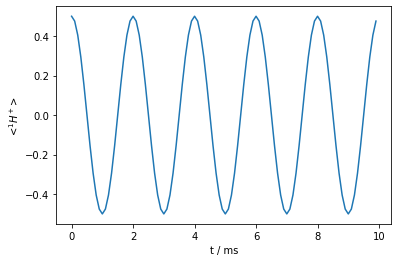

In [4]:
ex0=sl.ExpSys(v0H=500,Nucs='1H')    #Experimental system at 500 MHz with one 1H
ex0.set_inter('CS',i=0,Hz=500)     #Add a chemical shift to the system
ex1=ex0.copy()                      #Copy system for second system in exchange 
ex1.set_inter('CS',i=0,Hz=-500)    #Add a chemical shift to the second system
L=sl.Liouvillian(ex0,ex1)               #Generate a Liouvillian for the system
seq=L.Sequence(Dt=1/(10000))       #Sequence with a 25 microsecond length

rho=sl.Rho(rho0='1Hx',detect='1Hp')
rho.DetProp(seq,n=100)
_=rho.plot()

As we see, the system simply oscillates at the given input frequencies. Below, we can check what that frequency actually is, by taking the Fourier transform of the above signal, where we see that indeed it oscillates at +500 and -500 Hz.

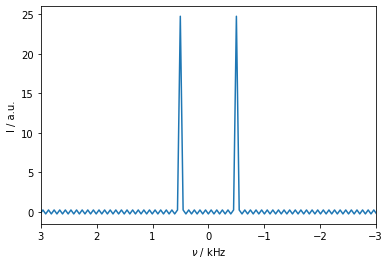

In [5]:
ax=rho.plot(FT=True)
_=ax.set_xlim([3,-3])

However, if we couple the two states together with an exchange matrix, the situation changes dramatically, yielding broadening in the spectrum, and if fast enough, coalescence of the peaks.

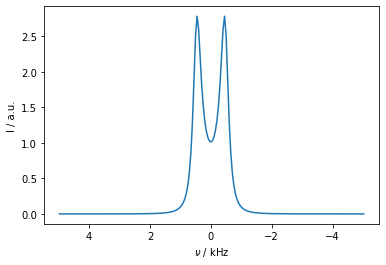

In [6]:
L.kex=sl.Tools.twoSite_kex(tc=5e-4)
rho=sl.Rho(rho0='1Hx',detect='1Hp')
rho.DetProp(seq,n=100)
_=rho.plot(FT=True)

### Exercise 1.1:
Typing any of the above objects (`ex0`,`ex1`,`L`,`seq`,`rho`) at the command line will produce a description of the object. Objects also have a `plot` function (`ex0`,`ex1` have a `plot_inter` function, although this is not so informative for isotropic interactions). Try this to get a feeling for what the critical settings are in this simulation. What is the role of each object in the simulation?

In [29]:
# Use this cell to investigate the different objects

```{toggle}
* ExpSys (ex0,ex1) : defines spins in the magnetic field, spins in the system, and interactions

* Liouvillian (L) : Contains each of the ExpSys objects and the Liouvillian matrix, as well as an exchange matrix (currently set to zeros).

* Sequence (seq) : Contains definitions of the field strengths, and defines length of propagation steps.

* Rho (rho) : Contains the initial state of the system and the detection matrix, as well as the signal.
```

Now, assume that the system is in one of two states, with chemical shift frequencies $\Omega_1$ and $\Omega_2$. This leads to a coupled set of equations, given by:

$$
\begin{eqnarray}
\frac{d}{dt}\langle\hat{S}_1^+\rangle&=&-i\Omega_1\langle\hat{S}_1^+\rangle+k_{21}\langle\hat{S}_2^+\rangle-k_{12}\langle\hat{S}_1^+\rangle \\
\frac{d}{dt}\langle\hat{S}_2^+\rangle&=&-i\Omega_2\langle\hat{S}_2^+\rangle-k_{21}\langle\hat{S}_2^+\rangle+k_{12}\langle\hat{S}_1^+\rangle
\end{eqnarray}
$$

These equations express both the transfer between state 1 and state 2, and the evolution due to the oscillation frequencies. 

We may express the exchange process as a matrix.

$$
\mathbf{k}=
\begin{pmatrix}
-k_{12} & k_{21} \\ k_{12} &- k_{21}
\end{pmatrix}
$$

Note that for this to be a valid exchange matrix, the columns must sum to one, and it must satisfy detailed balance, that is for populations $p_m$ and $p_n$, we require that $p_m/p_n=k_{n,m}/k_{m,n}$.

The system of equations can be expressed with a matrix including the oscillation, which yields the following differential equation:

$$
\frac{d}{dt}
\begin{pmatrix}
\langle\hat{S}^+_1\rangle \\ \langle\hat{S}^+_2\rangle
\end{pmatrix}
=
\begin{pmatrix}
-i\Omega_1 - k_{12} & k_{21} \\ k_{12} & -i\Omega_2 - k_{21}
\end{pmatrix}
\cdot
\begin{pmatrix}
\langle\hat{S}^+_1\rangle \\ \langle\hat{S}^+_2\rangle
\end{pmatrix}
$$

This matrix indicates that if we are in state 1, the phase of $\hat{S}_1^+$ will oscillate with frequency of $\Omega_1$, but it will also diffuse with rate $k_{12}$ to state 2, where it will oscillate with frequency $\Omega_2$ and also potentially diffuse back to state one (with rate $k_{21}$).

#### Some hints on 2x2 exchange matrices
A 2x2 exchange matrix has two eigenvalues. One must always be zero, corresponding to the equilibrium of the exchange. Any evolution of the matrix occurs with a rate constant given by the other eigenvalue. This eigenvalue is equal to $-(k_{12}+k_{21})$. We therefore often define $k=(k_{12}+k_{21})/2$, and $\tau_c=1/(2k)$.

### Exercise 1.2:
To understand exchange analytically, we often make some simplifying assumptions about the terms. First, we set $\Omega_1=\Delta\Omega/2$ and $\Omega_2=-\Delta\Omega/2$. We also assume symmetric exchange, such that $k_{12}=k_{21}=k$. This yields the following exchange matrix:

$$
\mathbf{k}=
\begin{pmatrix}
-i\Delta\Omega/2 - k & k \\ k & i\Delta\Omega/2 - k
\end{pmatrix}
$$

Find the eigenvalues of this matrix, where each eigenvalue represents the evolution of a signal in the NMR spectrum. We won't solve for the eigenvectors here, but these also play a role in the contributions of each signal.

Under what conditions do we observe two separated chemical shifts? What is $T_2$ in this case? What is $T_2$ if there is only one chemical shift?

Hint: $T_2$ is the negative inverse of the real part of the eigenvalues, whereas the imaginary part yields oscillation frequencies

The answer is given in multiple steps, so if you're not sure how to start, go ahead and open the first answer.

#### Part 1
```{toggle}
Eigenvalues are found by calculating the determinant of the matrix minus $\lambda\cdot\mathbb{1}$, setting it to zero, and solving for the values of $\lambda$ ($\mathbb{1}$ is an identity matrix)

$$
0=\det
\begin{pmatrix}
-i\Delta\Omega/2-k-\lambda & k \\ k & i\Delta\Omega/2-k-\lambda
\end{pmatrix}
$$
```

#### Part 2
```{toggle}
The determinant for a 2x2 matrix is calculated by taking the (0,0) element times the (1,1) element minus the (0,1) element times the (1,0) element.

$$
\begin{eqnarray}
0&=&(-i\Delta\Omega/2-k-\lambda)\cdot(i\Delta\Omega/2-k-\lambda)-k^2 \\
0&=&\lambda^2+2k\lambda+\frac{(\Delta\Omega)^2}{4}
\end{eqnarray}
$$
```

#### Part 3
```{toggle}
We can solve for the eigenvalues using the quadratic formula.

$$
\begin{eqnarray}
0&=&ax^2+bx+c \\
x&=&\frac{-b\pm\sqrt{b^2-4ac}}{2a}
\end{eqnarray}
$$

Then,

$$
\lambda=\frac{-2k\pm\sqrt{4k^2-(\Delta\Omega)^2}}{2}
$$
```

#### Part 4
```{toggle}
The real part of the eigenvalues is the negative inverse of $T_2$, whereas the imaginary part is the frequency. When $2k>\Delta\Omega$, then the eigenvalues are strictly real. This means that there is only a single frequency (at 0) in the spectrum, but a complex lineshape with two decay rates. On the other hand, if $2k<\Delta\Omega$, then two distinct frequencies emerge. The real part is then only $-k$, so $T_2=1/k$.

$$
\begin{matrix}
2k>>\Delta\Omega & T_2=\infty,1/(2k) & \Omega=0 \\
2k>\Delta\Omega & T_2=1/(k\mp\sqrt{k^2-(\Delta\Omega/2)^2}) & \Omega=0 \\
2k=\Delta\Omega & T_2=1/k & \Omega=0 \\
2k<\Delta\Omega & T_2=1/k & \Omega=\pm\sqrt{(\Delta\Omega/2)^2-k^2} \\
2k<<\Delta\Omega & T_2=1/k & \Omega=\pm\Delta\Omega/2
\end{matrix}
$$
Note that when $k>\Delta\Omega$, there are two peaks with the same apparent chemical shift. As $k$ gets large, the contribution of $T_2=1/(2k)$ becomes smaller, such that the peak becomes increasingly narrow, rather than wide.
```

### Exercise 1.3
Above, we set up a simulation with two different chemical shifts in exchange ($\pm$500 Hz, so $\Delta\Omega=2*\pi*1000$ rad/s). Adjust $k$ to the different conditions in the solution above to observe the effect.

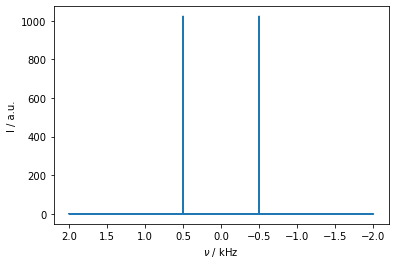

In [30]:
k=0
L.kex=[[-k,k],[k,-k]]

_=OneD(L)

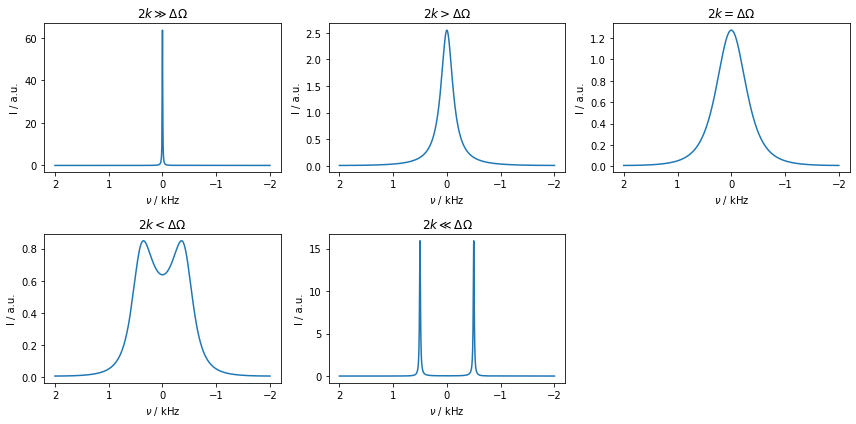

In [31]:
fig=plt.figure(figsize=[12,6])
ax=[fig.add_subplot(2,3,k+1) for k in range(5)]
DeltaCS=L.H[0].expsys[0]['Hz']-L.H[1].expsys[0]['Hz']  #Change in chemical shift (Hz)
sqrt0=2*np.pi*DeltaCS/2   #This is where the square root is zero
k0=[50*sqrt0,2*sqrt0,sqrt0,sqrt0/2,sqrt0/50]
titles=[rf'$2k{sign}\Delta\Omega$' for sign in ['\gg','>','=','<','\ll']]

for a,k,title in zip(ax,k0,titles):
    L.kex=[[-k,k],[k,-k]]
    OneD(L,ax=a)
    a.set_title(title)
_=fig.tight_layout()

The full Liouville matrix for the above system is an 8x8 matrix, but most terms do not actually enter into the calculation, reducing to the 2x2 matrix already discussed. SLEEPY will automatically pick out the required terms. We may then adjust the exchange matrix and extract the eigenvalues of the Liouville matrix for the conditions above, in order to find $T_2$ and the resonance frequencies.

In [32]:
rho=sl.Rho('S0x','S0p')
rho_r,_=rho.ReducedSetup(L.U(.1))  
L_r=rho_r.L   # The reduced Liouvillian is not returned directly
DeltaCS=L.H[0].expsys[0]['Hz']-L.H[1].expsys[0]['Hz']  #Change in chemical shift (Hz)
sqrt0=2*np.pi*DeltaCS/2   #This is where the square root is zero
k0=[50*sqrt0,2*sqrt0,sqrt0,sqrt0/2,sqrt0/50]
for k in k0:
    L.kex=[[-k,k],[k,-k]]
    Lambda=np.linalg.eig(L_r[0].L(0))[0]
    print(f'k={k:.1} s^-1, '+\
          f'T2={-1e3/Lambda[0].real:5.2f} ms, T2={-1e3/Lambda[1].real:5.2f} ms,'+\
          f'f={-Lambda[0].imag/2/np.pi:6.1f} Hz, f={-Lambda[1].imag/2/np.pi:6.1f} Hz')

k=2e+05 s^-1, T2=31.83 ms, T2= 0.00 ms,f=  -0.0 Hz, f=  -0.0 Hz
k=6e+03 s^-1, T2= 1.19 ms, T2= 0.09 ms,f=  -0.0 Hz, f=   0.0 Hz
k=3e+03 s^-1, T2= 0.32 ms, T2= 0.32 ms,f=  -0.0 Hz, f=   0.0 Hz
k=2e+03 s^-1, T2= 0.64 ms, T2= 0.64 ms,f=-433.0 Hz, f= 433.0 Hz
k=6e+01 s^-1, T2=15.92 ms, T2=15.92 ms,f=-499.9 Hz, f= 499.9 Hz


Note that we have assumed symmetric exchange. However, similar effects occur for asymmetric exchange. These are simulated below for the same conditions. The `twoSite_kex` tool builds an exchange matrix for us, defined by a correlation time $1/(2k)$ and a population for the first state.

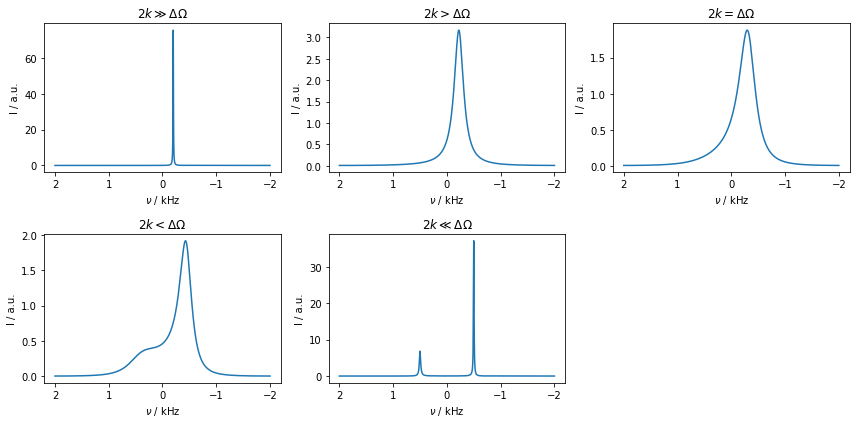

In [33]:
fig=plt.figure(figsize=[12,6])
ax=[fig.add_subplot(2,3,k+1) for k in range(5)]
DeltaCS=L.H[0].expsys[0]['Hz']-L.H[1].expsys[0]['Hz']  #Change in chemical shift (Hz)
sqrt0=2*np.pi*DeltaCS/2   #This is where the square root is zero
k0=[50*sqrt0,2*sqrt0,sqrt0,sqrt0/2,sqrt0/50]
titles=[rf'$2k{sign}\Delta\Omega$' for sign in ['\gg','>','=','<','\ll']]

for a,k,title in zip(ax,k0,titles):
    L.kex=sl.Tools.twoSite_kex(tc=1/(2*k),p1=.3)
    OneD(L,ax=a)
    a.set_title(title)
_=fig.tight_layout()

We repeat the eigenvalue calculation.

In [34]:
rho=sl.Rho('S0x','S0p')
rho_r,_=rho.ReducedSetup(L.U(.1))
L_r=rho_r.L   # The reduced Liouvillian is not returned directly
for k in k0:
    L.kex=sl.Tools.twoSite_kex(tc=1/(2*k),p1=.3)
    Lambda=np.linalg.eig(L_r[0].L(0))[0]
    print(f'k={k:.1} s^-1,'+\
          f'T2={-1e3/Lambda[0].real:5.2f} ms, T2={-1e3/Lambda[1].real:5.2f} ms,'+\
          f'f={-Lambda[0].imag/2/np.pi:5.1f} Hz, f={-Lambda[1].imag/2/np.pi:5.1f} Hz')

k=2e+05 s^-1,T2= 0.00 ms, T2=37.89 ms,f=-200.0 Hz, f=200.0 Hz
k=6e+03 s^-1,T2= 0.08 ms, T2= 1.51 ms,f=-223.6 Hz, f=223.6 Hz
k=3e+03 s^-1,T2= 0.19 ms, T2= 0.87 ms,f=-316.2 Hz, f=316.2 Hz
k=2e+03 s^-1,T2= 0.44 ms, T2= 1.15 ms,f=-447.2 Hz, f=447.2 Hz
k=6e+01 s^-1,T2=11.37 ms, T2=26.53 ms,f=-499.9 Hz, f=499.9 Hz


### Exercise 1.4
What do you see that's different about the results of the eigenvalue calculation above vs. symmetric exchange.
```{toggle}
There are always two unique frequencies for asymmetric exchange. In symmetric exchange, when $2k>\Delta\Omega$, a coalescence condition occured and the two peaks collapse into a single frequency. In asymmetric exchange, no coalescence condition exists. One peak just becomes increasingly weak until it is effectively invisible.
```

In chemical exchange in 1D, in principle, we can extract populations of the two states and rates of exchange between them, simply by fitting the spectrum. However, other sources of relaxation (e.g. tumbling in solution) will contribute to the broadening, complicating the extraction of exchange rates and populations from the spectra alone. In this case, we usually need a reference sample which should have the same $T_2$ without exchange present. This is not always available, so one may need to consider other approaches.

A second challenge is what to do when there is not significant broadening in the 1D experiment; indeed, unless $2k\approx\Delta\Omega$, this is the case.

## Chemical Exchange in 2D

In the 1D spectra above, we get significant broadening for the case that rate of exchange ($2k$) is on the order of the size in chemical shift. However, what should we do if this is not the case? The first possibility is that motion is much slower than the chemical shift size. Then, we obtain narrow lines, where broadening is likely dominated by other sources of relaxation so that we cannot easily extract exchange rates.

In this case, we may use Exchange Spectroscopy (EXSY). This is a 2D experiment, where we evolve in the indirect dimension, flip the magnetization to the *z*-axis, wait to allow exchange to occur, and then flip magnetization back to the *x*-axis to observe the emergence of new frequencies.

We include some $T_2$ relaxation to broaden the spectra slightly.

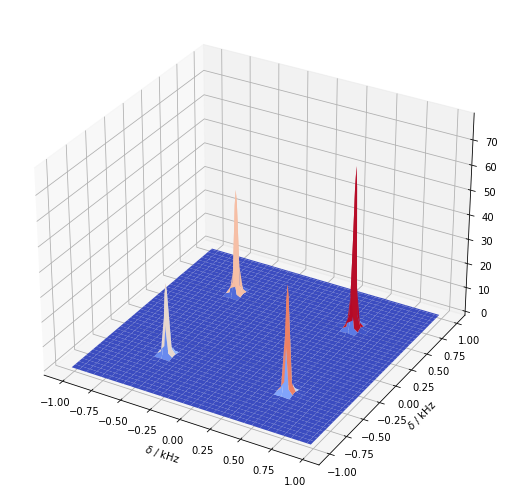

In [13]:
L.kex=sl.Tools.twoSite_kex(tc=.2,p1=0.6)
L.add_relax('T2',i=0,T2=.05)

_=EXSY(L,dly=1,buildup=False) #dly is the length of time between flip up and flip down

### Exercise 2.1
Write formulas for the peak integrals for a delay much longer than the length of the correlation time of exchange. That is, what is $I_{1,1}$, $I_{1,2}$, $I_{2,1}$, $I_{2,2}$ as a function of $p_1$ and $p_2$, where $I_{1,2}$ is the peak corresponding to magnetization starting in state one and ending in state 2, for example, and $p_1$ and $p_2$


We can take the populations as probabilities, and so the probability of starting in state 1 and ending in state one is simply $p_1*p_1$ ($=I_{1,1})$. Find the others by analogy.

```{toggle}
$$
\begin{eqnarray}
I_{1,1}&=&p_1^2 \\ 
I_{1,2}&=&p_1p_2 \\
I_{2,1}&=&p_1p_2 \\
I_{2,2}&=&p_2^2
\end{eqnarray}
$$
```

### Exercise 2.2

For a given delay, $\tau$, and exchange rate constants $k_{12}$ and $k_{21}$, give the peak intensities.

Hint: Give your answer in terms of $p_1$, $p_2$, and $2k$ ($2k=k_1+k_2$).

```{toggle}
$$
\begin{eqnarray}
I_{1,1}(\tau)&=&p_1^2+(p_1-p_1^2)\exp(-2k\tau) \\
I_{1,2}(\tau)&=&p_1p_2(1-\exp(-2k\tau)) \\
I_{2,1}(\tau)&=&p_1p_2(1-\exp(-2k\tau)) \\
I_{2,2}(\tau)&=&p_2^2+(p_2-p_2^2)\exp(-2k\tau)
\end{eqnarray}
$$
```

Below, we plot the buildup of peak intensities for our system, where we observe the expected behavior. Dotted lines show the result from the formulas above.

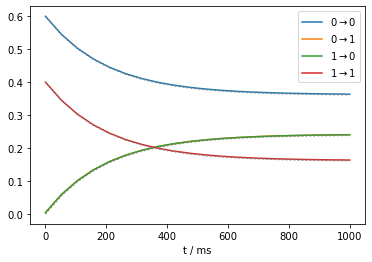

In [14]:
dly=1
ax=EXSY(L,dly=dly)
t=np.linspace(0,dly,20)
k=L.kex[0,1]+L.kex[1,0]
p1=1/(1+L.kex[1,0]/L.kex[0,1])
p2=1-p1
ax.plot(t*1e3,p1**2+(p1-p1**2)*np.exp(-t*k),linestyle=':',color='grey')
ax.plot(t*1e3,p2**2+(p2-p2**2)*np.exp(-t*k),linestyle=':',color='grey')
ax.plot(t*1e3,p1*p2*(1-np.exp(-t*k)),linestyle=':',color='grey')

### Exercise 2.3
When, roughly, is exchange too fast (or two slow) for the EXSY experiment? What are the problems that arise? Edit `k` in the cell below. When `k` is large, you may want to shorten the total delay in the second call to EXSY. Note that we have added $T_1$ relaxation to the Liouvillian (why is this relevant? Can you edit the buildup formulas accordingly?)

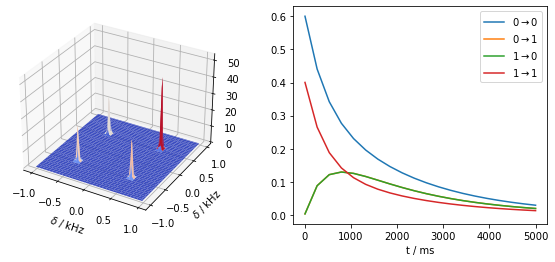

In [16]:
k=1
L.clear_relax()
L.add_relax('T2',i=0,T2=.05)
L.add_relax('T1',i=0,T1=2)
L.kex=sl.Tools.twoSite_kex(tc=1/(2*k),p1=0.6)

fig=plt.figure(figsize=[10,4])
ax=[fig.add_subplot(1,2,1,projection='3d'),fig.add_subplot(1,2,2)]
EXSY(L,dly=1,buildup=False,ax=ax[0])
_=EXSY(L,dly=5,buildup=True,ax=ax[1])

```{toggle}
Around $k>1500$, the 2D spectrum becomes too broad to separate the individual peaks and so we can no longer easily extract exchange rates from the EXSY buildup curves. On the other hand, if $k<0.15$, the peaks decay faster than any significant transfer occurs. Then, the formulas for the peak intensities are

$$
\begin{eqnarray}
I_{1,1}(\tau)&=&(p_1^2+(p_1-p_1^2)\exp(-k\tau))\cdot\exp(-\tau/T_1) \\
I_{1,2}(\tau)&=&p_1p_2(1-\exp(-k\tau))\cdot\exp(-\tau/T_1) \\
I_{2,1}(\tau)&=&p_1p_2(1-\exp(-k\tau))\cdot\exp(-\tau/T_1) \\
I_{2,2}(\tau)&=(&p_2^2+(p_2-p_2^2)\exp(-k\tau))\cdot\exp(-\tau/T_1)
\end{eqnarray}
$$

Then, the relevant parameters are $\Delta\Omega$, where if $k>>\Delta\Omega$, peaks become too broad, and if $k<<1/T_1$, then signal intensity is lost too quickly to use EXSY

```

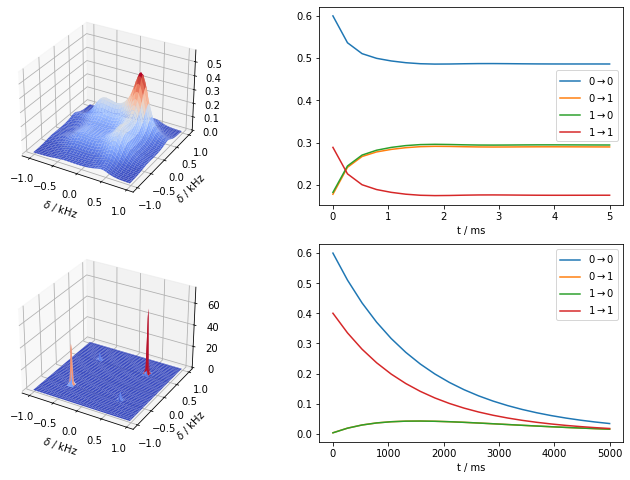

In [22]:
fig=plt.figure(figsize=[12,8])
ax=[fig.add_subplot(2,2,1,projection='3d'),fig.add_subplot(2,2,2),
   fig.add_subplot(2,2,3,projection='3d'),fig.add_subplot(2,2,4)]

k=1500
L.kex=sl.Tools.twoSite_kex(tc=1/(2*k),p1=0.6)
EXSY(L,dly=1,buildup=False,ax=ax[0])
_=EXSY(L,dly=.005,buildup=True,ax=ax[1])

k=0.15
L.kex=sl.Tools.twoSite_kex(tc=1/(2*k),p1=0.6)
EXSY(L,dly=1,buildup=False,ax=ax[2])
_=EXSY(L,dly=5,buildup=True,ax=ax[3])

## $R_{1\rho}$ and CPMG
Thus far, our rate of exchange has been near the difference in chemical shift ($\Delta\Omega$), or slower. The next question is, what can we do when it is faster? In this case, we have the options of measuring $R_{1\rho}$ or CPMG (Carr-Purcell-Meiboom-Gill). The former experiment simply applies a spin-locking field to magnetization with a given frequency, whereas the latter uses a train of pulses to periodically refocus the magnetization. Applied on-resonance, the performance of the two experiments is fairly similar.

Below, we first calculate the lineshape for $k=1\cdot10^5$ s, where we note that the resulting line is fairly narrow and from which it would be difficult to extract dynamics information.

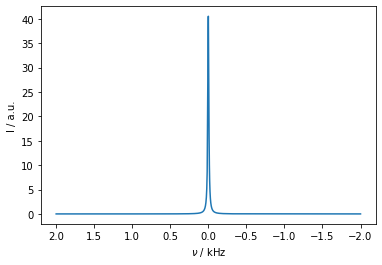

In [7]:
k=1e5
L.clear_relax()
L.kex=sl.Tools.twoSite_kex(tc=1/(2*k))
_=OneD(L)

Then, we would like to obtain more information. For this we can apply the $R_{1\rho}$ or CPMG experiments. These are shown below.

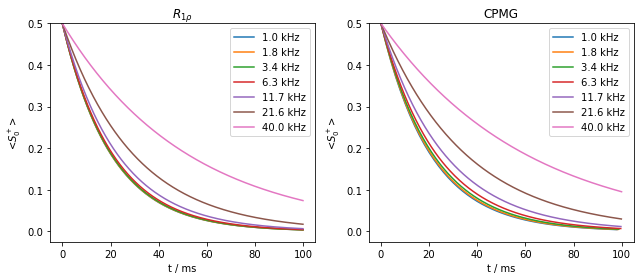

In [8]:
fig,ax=plt.subplots(1,2,figsize=[9,4])
R1p(L,dly=0.1,ax=ax[0])
ax[0].set_title(r'$R_{1\rho}$')
CPMG(L,dly=0.1,ax=ax[1])
ax[1].set_title('CPMG')
fig.tight_layout()

Note that the two sets of experiments yield fairly similar results; for this case, the information content is about the same. However, $R_{1\rho}$ may be applied off-resonance, yielding some additional information about the relaxation (not investigated here).

### Exercise 3.1

The dispersion as a function of spin-lock strength or pulse-frequency can be fit to obtain the amplitude and correlation time of exchange. At what rate does the dispersion vanish for each experiment? Adjust `k` below.

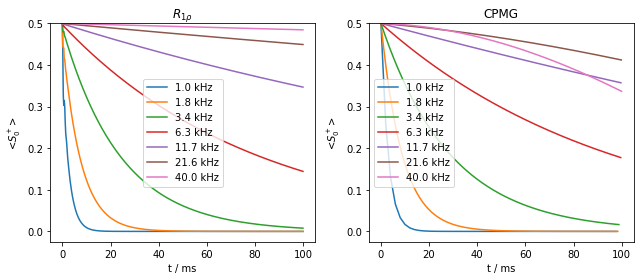

In [15]:
k=1e3
L.kex=sl.Tools.twoSite_kex(1/(2*k))

fig,ax=plt.subplots(1,2,figsize=[9,4])
R1p(L,dly=0.1,ax=ax[0])
ax[0].set_title(r'$R_{1\rho}$')
CPMG(L,dly=0.1,ax=ax[1])
ax[1].set_title('CPMG')
fig.tight_layout()

```{toggle}
Differences between $R_{1\rho}$ curves are effectively gone for $k>10^6$ s$^{-1}$. For CPMG, there are some differences in the curves, but these never completely vanish, and cannot be used for extracting the rate of exchange.

```

### Exercise 3.2

Below, we plot $R_{1\rho}$ curves for $k=1\cdot10^4$ s$^{-1}$, first with $\Delta\Omega/(2\pi)$=1000 Hz, and $p_1=p_2=0.5$. In the second calculation, we adjust $p_1=0.9$ and $p_2=0.1$, but increase $\Delta\Omega/(2\pi)$=1667 Hz. What do you notice about the two sets of curves?

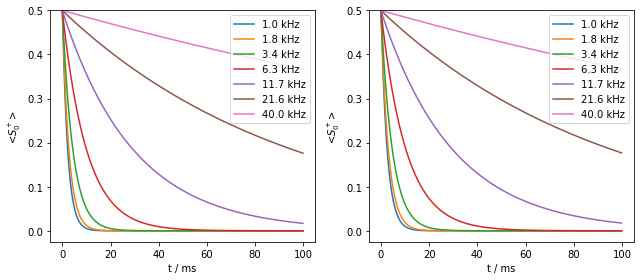

In [16]:
k=1e4
L.kex=sl.Tools.twoSite_kex(1/(2*k))

p1=0.9
DelCS0=L.H[0].expsys[0]['Hz']-L.H[1].expsys[0]['Hz']
DelCS=np.sqrt(.25*DelCS0**2/(p1*(1-p1)))

ex0=sl.ExpSys(v0H=500,Nucs='1H')    #Experimental system at 500 MHz with one 1H
ex0.set_inter('CS',i=0,Hz=DelCS*(1-p1))     #Add a chemical shift to the system
ex1=ex0.copy()                      #Copy system for second system in exchange 
ex1.set_inter('CS',i=0,Hz=-DelCS*p1)    #Add a chemical shift to the second system
L1=sl.Liouvillian(ex0,ex1)               #Generate a Liouvillian for the system
L1.kex=sl.Tools.twoSite_kex(1/(2*k),p1=p1)

fig,ax=plt.subplots(1,2,figsize=[9,4])
R1p(L,dly=.1,ax=ax[0])
R1p(L1,dly=.1,ax=ax[1])
fig.tight_layout()

```{toggle}
Despite having different input parameters, the two sets of relaxation curves are all nearly the same. This is because for faster exchange, the term $p_1p_2\Delta\Omega^2$ scales the relaxation. Then, it is not possible to separate the populations from the change in chemical shift.
```

Adjust `k` below. Can you introduce differences in the curves? Under what conditions? See our more extensive tutorial [here](http://sleepy-nmr.org/html/Chapter2/Ch2_BMRD.html) for further explanation, and the following reference:

V.Z. Miloushev, A.G. Palmer. [*J. Magn. Reson.*](https://doi.org/10.1016/j.jmr.2005.07.023), **2015**, 177, 221-227

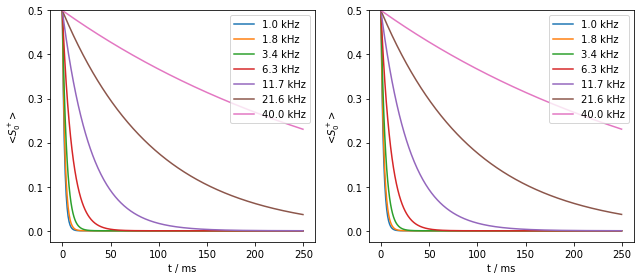

In [20]:
k=1e4
L.kex=sl.Tools.twoSite_kex(1/(2*k))
L1.kex=sl.Tools.twoSite_kex(1/(2*k),p1=p1)

fig,ax=plt.subplots(1,2,figsize=[9,4])
R1p(L,dly=.25,ax=ax[0])
R1p(L1,dly=.25,ax=ax[1])
fig.tight_layout()

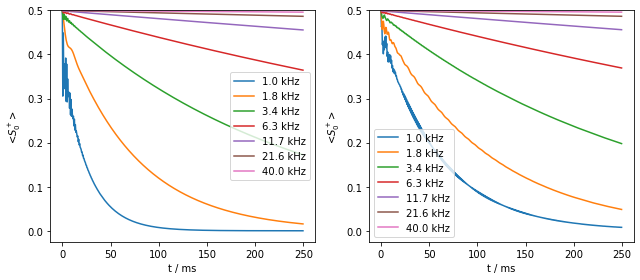

In [18]:
k=1e2
L.kex=sl.Tools.twoSite_kex(1/(2*k))
L1.kex=sl.Tools.twoSite_kex(1/(2*k),p1=p1)

fig,ax=plt.subplots(1,2,figsize=[9,4])
R1p(L,dly=.25,ax=ax[0])
R1p(L1,dly=.25,ax=ax[1])
fig.tight_layout()

```{toggle}
Diffences in the curves emerge for $k<1\cdot10^3$ s$^{-1}$, with these becoming more clear around $k=1\cdot10^2$ s$^{-1}$. For slower exchange and low powers, it becomes again possible to separate populations from the change in chemical shift (see the reference above for more details).
```

## CEST
Our experiments up until now assume a relatively large population on both states in exchange. However, what can we do if one population is too small to observe as a resonance in the spectrum? In this case, we may use the Chemical Exchange Saturation Transfer experiment, or CEST. This experiment applies a saturating field onto longitudinal magnetization followed by flipping magnetization to the *x*-axis for detection. If the saturating field is on-resonance with the main peak, then as expected, the signal is reduced. However, if a peak corresponding to a low population is on-resonance, then the main peak also saturates. This is demonstrated below, where we first plot the 1D experiment, followed by the CEST saturation profile.

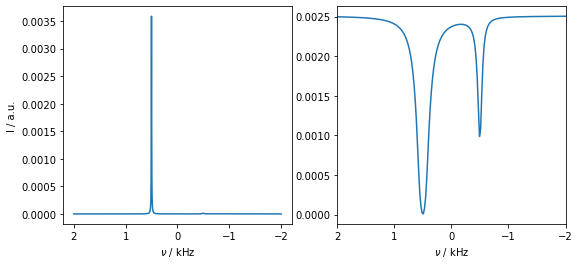

In [146]:
L.clear_relax()
L.add_relax('T2',i=0,T2=.05)
L.add_relax('T1',i=0,T1=2)
L.add_relax('recovery') #Causes magnetization to recover to thermal equilibrium
L.kex=sl.Tools.twoSite_kex(tc=1e-2,p1=0.98)

fig,ax=plt.subplots(1,2,figsize=[9,4])
OneD(L,ax=ax[0])
_=CEST(L,dly=1,v1=25,ax=ax[1])

The above simulation has set the second peak to be just 2% of the total signal. However, the peak is easily visible in the saturation profile. 

### Exercise 4.1
Below, `dly` gives the length of the CEST saturation period in seconds, and `v1` gives the strength of the saturation field in Hz. Fix the experiment! What should one consider when setting these parameters?

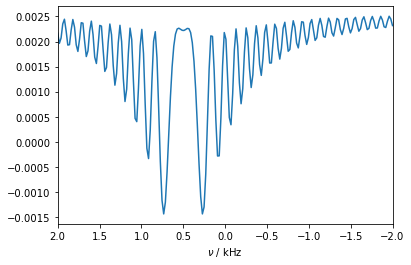

In [147]:
_=CEST(L,dly=.01,v1=500)

```{toggle}
Set `dly`=1 s, and `v1`=25 Hz. 

Using too much power saturates the whole spectrum, and so we lose detailed features. However, we need to apply the field long enough that saturation actually occurs. 

```

### Exercise 4.2
How does the CEST experiment depend on the rate of exchange? Adjust `k` below to determine where CEST works or fails. Don't forget to fix `dly` and `v1` based on your investigation above.

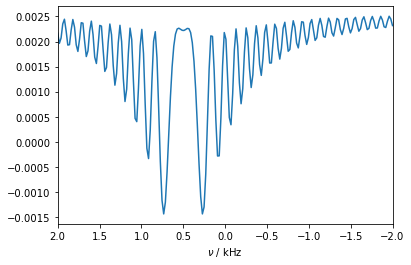

In [150]:
k=50
L.kex=sl.Tools.twoSite_kex(tc=1/(2*k),p1=0.98)

_=CEST(L,dly=.01,v1=500)

```{toggle}
When `k` approches ~2000 s$^{-1}$, peaks begin to coalesce, making it more difficult to identify the location of the second peak. On the other hand, if `k` becomes too small ($k<0.5$ s$^{-1}$), then saturation on the weak resonance does not get transferred to the main resonance quickly enough.
```

## Matching Game
Below, we have prepared four Liouvillian matrices (objects), corresponding to different populations and correlation times. Which experiment would you apply for each Liouvillian? Try out each experiment (use CPMG or $R_{1p}$, but not both, since their performance is very similar). Once  you reveal the answer, you will also see the rate constants (`k`) and populations (`p1`).

Hint: Some Liouvillians will work with more than one experiment and vice-versa, but there is a "best" one-to-one assigment. You can adjust the input parameters for the experiments, but this should not be required.

In [158]:
ex0=sl.ExpSys(v0H=500,Nucs='1H')    #Experimental system at 500 MHz with one 1H
ex0.set_inter('CS',i=0,Hz=500)     #Add a chemical shift to the system
ex1=ex0.copy()                      #Copy system for second system in exchange 
ex1.set_inter('CS',i=0,Hz=-500)    #Add a chemical shift to the second system
L1,L2,L3,L4=[sl.Liouvillian(ex0,ex1) for _ in range(4)]
for L,(k,p1) in zip([L1,L2,L3,L4],pars):
    L.add_relax('T2',i=0,T2=0.05)
    L.add_relax('T1',i=0,T1=2)
    L.kex=sl.Tools.twoSite_kex(k,p1)

Reveal the cell below for our suggested best answer

L1: k=5e+01, p1=0.95
L2: k=5e+04, p1=0.75
L3: k=5.0, p1=0.35
L4: k=5e+02, p1=0.60


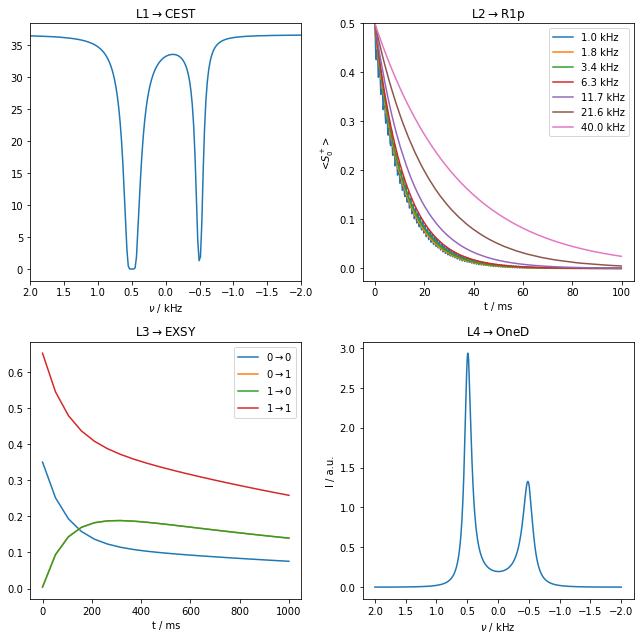

In [159]:
fig,ax=plt.subplots(2,2,figsize=[9,9])
ax=ax.flatten()
for k,(L,exp,a) in enumerate(zip([L1,L2,L3,L4],[CEST,R1p,EXSY,OneD],ax)):
    exp(L,ax=a)
    a.set_title(fr'L{k+1}$\rightarrow${exp.__name__}')
fig.tight_layout()

for k,(L,(tc,p1)) in enumerate(zip([L1,L2,L3,L4],pars)):
    print(f'L{k+1}: k={1/(2*tc):.2}, p1={p1:4.2f}')